In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import mlflow
import mlflow.tensorflow

warnings.filterwarnings('ignore')

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('rossmann_lstm.log'),
        logging.StreamHandler()  # This handles console output
    ],
    force=True  # This forces reconfiguration if logging was already set up
)

# Get logger
logger = logging.getLogger(__name__)


logger.info("Starting Deep Learning LSTM Model for Rossmann Sales Forecasting")

2025-06-25 11:23:24,756 - INFO - Starting Deep Learning LSTM Model for Rossmann Sales Forecasting


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Use the correct path to your file in Google Drive
file_path = '/content/drive/MyDrive/Colab_Notebooks/processed_data_set/train_cleaned.csv'
# Load the CSV into a variable
train_df = pd.read_csv(file_path,parse_dates=['Date'])



logger.info(f"Loaded data with shape: {train_df.shape}")

2025-06-25 11:24:03,856 - INFO - Loaded data with shape: (1017155, 27)


In [6]:
# 1. ISOLATE TIME SERIES DATA
logger.info("Preparing time series data...")

# Filter open stores and aggregate by date
daily_sales = train_df[train_df['Open'] == 1].groupby('Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)


2025-06-25 11:24:19,428 - INFO - Preparing time series data...


In [7]:
# Fill any missing dates
date_range = pd.date_range(start=daily_sales['Date'].min(),
                          end=daily_sales['Date'].max(),
                          freq='D')
daily_sales = daily_sales.set_index('Date').reindex(date_range, method='ffill').reset_index()
daily_sales.columns = ['Date', 'Sales']

print(f"Time series data shape: {daily_sales.shape}")
print(f"Date range: {daily_sales['Date'].min()} to {daily_sales['Date'].max()}")

Time series data shape: (942, 2)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


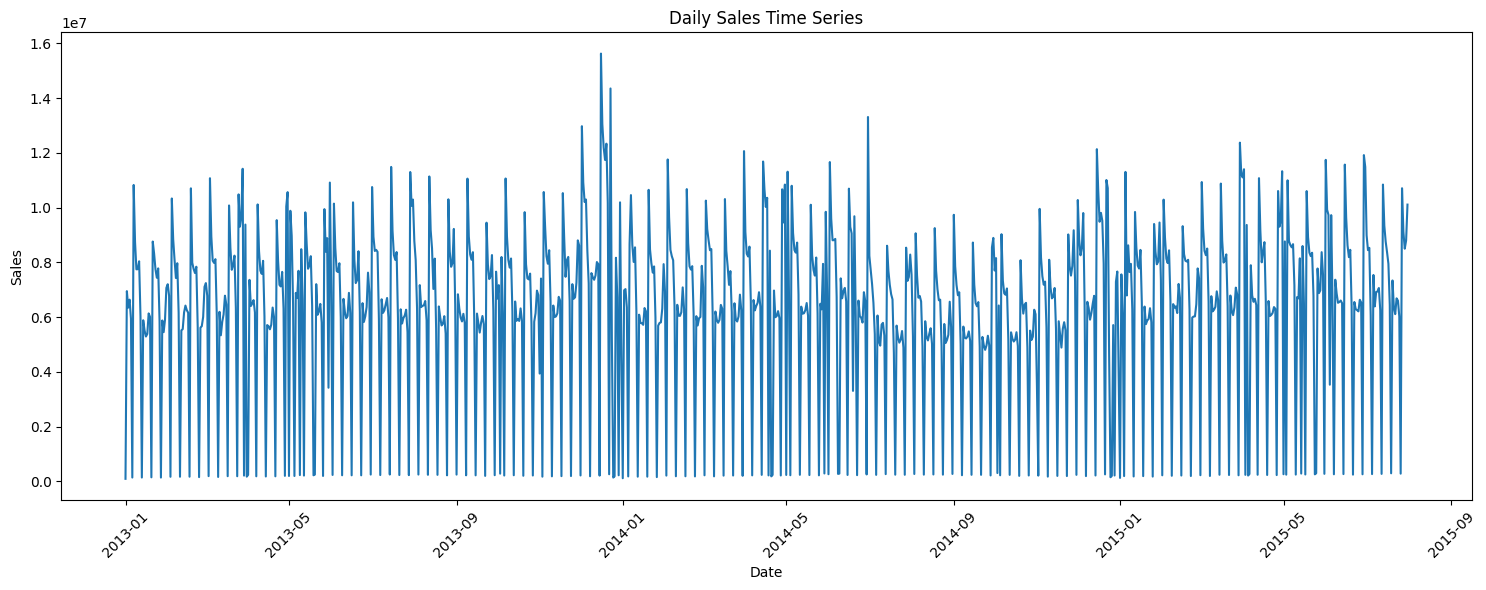

In [8]:
# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'])
plt.title('Daily Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2025-06-25 11:24:25,588 - INFO - Checking time series stationarity...



=== Original Sales Data ===


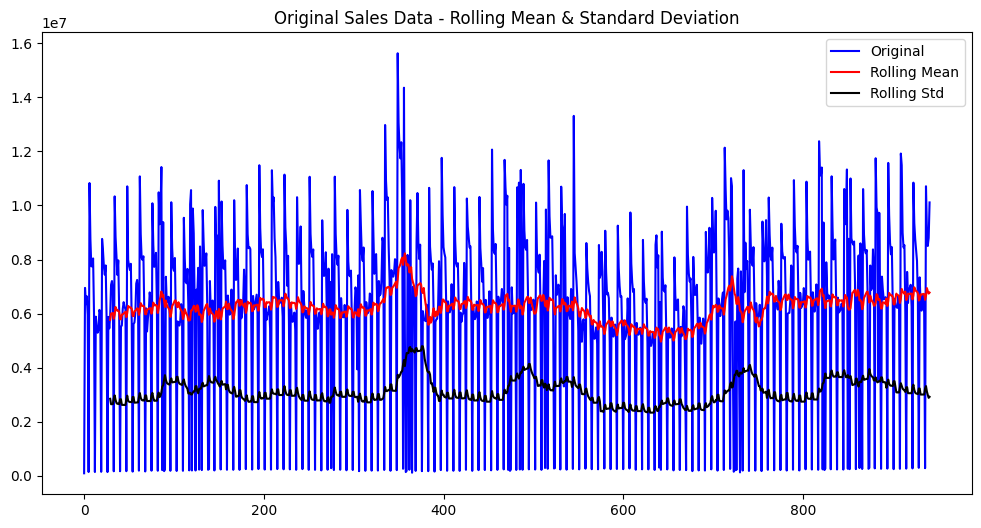

ADF Statistic: -4.761614524595615
p-value: 6.436731330559343e-05
Critical Values:
	1%: -3.437470108019385
	5%: -2.8646832620852853
	10%: -2.5684436698650503
Series is stationary


In [9]:
# 2. CHECK STATIONARITY
logger.info("Checking time series stationarity...")

def check_stationarity(timeseries, title):
    """Check stationarity using Augmented Dickey-Fuller test"""
    print(f'\n=== {title} ===')

    # Rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{title} - Rolling Mean & Standard Deviation')
    plt.show()

    # ADF test
    adf_result = adfuller(timeseries.dropna())
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')

    if adf_result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is not stationary")
        return False

# Check original series
is_stationary = check_stationarity(daily_sales['Sales'], 'Original Sales Data')


In [10]:
# 3. DIFFERENCING IF NEEDED
logger.info("Applying differencing if needed...")

sales_data = daily_sales['Sales'].copy()

if not is_stationary:
    # First differencing
    sales_diff = sales_data.diff().dropna()

    # Check stationarity after differencing
    is_stationary_diff = check_stationarity(sales_diff, 'First Differenced Sales Data')

    if not is_stationary_diff:
        # Second differencing if needed
        sales_diff2 = sales_diff.diff().dropna()
        check_stationarity(sales_diff2, 'Second Differenced Sales Data')
        final_series = sales_diff2
    else:
        final_series = sales_diff
else:
    final_series = sales_data

2025-06-25 11:24:27,472 - INFO - Applying differencing if needed...


2025-06-25 11:24:30,392 - INFO - Analyzing autocorrelation and partial autocorrelation...


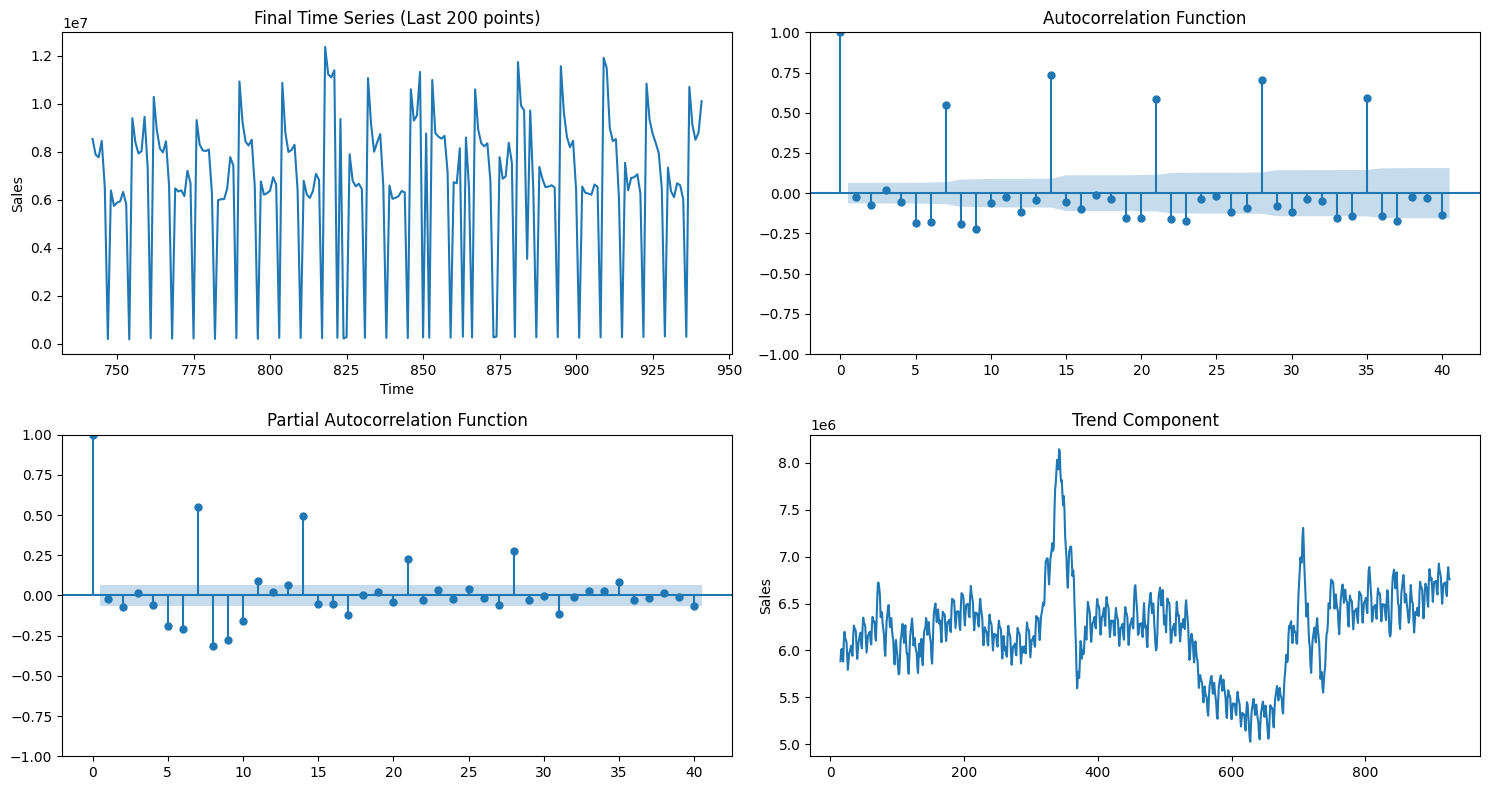

In [11]:
# 4. AUTOCORRELATION AND PARTIAL AUTOCORRELATION
logger.info("Analyzing autocorrelation and partial autocorrelation...")

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(final_series[-200:])  # Plot last 200 points
plt.title('Final Time Series (Last 200 points)')
plt.xlabel('Time')
plt.ylabel('Sales')

plt.subplot(2, 2, 2)
plot_acf(final_series.dropna(), ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')

plt.subplot(2, 2, 3)
plot_pacf(final_series.dropna(), ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')

plt.subplot(2, 2, 4)
# Seasonal decomposition
if len(sales_data) > 365:
    decomposition = seasonal_decompose(sales_data, model='additive', period=30)
    decomposition.trend.plot(ax=plt.gca())
    plt.title('Trend Component')
    plt.ylabel('Sales')

plt.tight_layout()
plt.show()

In [12]:
# 5. TRANSFORM TO SUPERVISED LEARNING DATA
logger.info("Transforming time series to supervised learning format...")

def create_sequences(data, seq_length):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Use original sales data for LSTM (LSTM can handle non-stationary data)
sales_values = daily_sales['Sales'].values

# Parameters
sequence_length = 30  # Use 30 days to predict next day
train_size = int(len(sales_values) * 0.8)

# Split data
train_data = sales_values[:train_size]
test_data = sales_values[train_size:]

print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")


2025-06-25 11:24:33,091 - INFO - Transforming time series to supervised learning format...


Train data size: 753
Test data size: 189


In [13]:
# 6. SCALE DATA TO (-1, 1) RANGE
logger.info("Scaling data to (-1, 1) range...")

scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

# Create sequences
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


2025-06-25 11:24:35,200 - INFO - Scaling data to (-1, 1) range...


X_train shape: (723, 30, 1)
X_test shape: (159, 30, 1)
y_train shape: (723,)
y_test shape: (159,)


In [14]:
# 7. BUILD LSTM REGRESSION MODEL
logger.info("Building LSTM model...")

# Model architecture
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\n=== MODEL ARCHITECTURE ===")
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)


2025-06-25 11:24:37,671 - INFO - Building LSTM model...



=== MODEL ARCHITECTURE ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train model
logger.info("Training LSTM model...")

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

2025-06-25 11:24:39,957 - INFO - Training LSTM model...


Epoch 1/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1846 - mae: 0.3110

2025-06-25 11:24:47,680 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.1833 - mae: 0.3099 - val_loss: 0.1774 - val_mae: 0.3035
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1427 - mae: 0.2657 - val_loss: 0.1849 - val_mae: 0.3465
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1570 - mae: 0.2878 - val_loss: 0.1788 - val_mae: 0.3306
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1633 - mae: 0.2972

2025-06-25 11:24:51,658 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1631 - mae: 0.2969 - val_loss: 0.1701 - val_mae: 0.3042
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1503 - mae: 0.2812 - val_loss: 0.1782 - val_mae: 0.3420
Epoch 6/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1684 - mae: 0.3052

2025-06-25 11:24:54,136 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1674 - mae: 0.3040 - val_loss: 0.1693 - val_mae: 0.3186
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1628 - mae: 0.2970 - val_loss: 0.1707 - val_mae: 0.3258
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1519 - mae: 0.2891 - val_loss: 0.1704 - val_mae: 0.3232
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1688 - mae: 0.3109

2025-06-25 11:24:56,740 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1682 - mae: 0.3100 - val_loss: 0.1666 - val_mae: 0.2912
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1509 - mae: 0.2803

2025-06-25 11:24:58,005 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1513 - mae: 0.2808 - val_loss: 0.1665 - val_mae: 0.3005
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1534 - mae: 0.2885

2025-06-25 11:24:58,833 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1536 - mae: 0.2886 - val_loss: 0.1659 - val_mae: 0.2977
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1473 - mae: 0.2743 - val_loss: 0.1725 - val_mae: 0.3294
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1508 - mae: 0.2912

2025-06-25 11:25:01,769 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1510 - mae: 0.2911 - val_loss: 0.1637 - val_mae: 0.3054
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1515 - mae: 0.2930 - val_loss: 0.1660 - val_mae: 0.3062
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1529 - mae: 0.2842 - val_loss: 0.1657 - val_mae: 0.3142
Epoch 16/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1338 - mae: 0.2690

2025-06-25 11:25:04,956 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1345 - mae: 0.2698 - val_loss: 0.1621 - val_mae: 0.3018
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1552 - mae: 0.2898 - val_loss: 0.1623 - val_mae: 0.2972
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1533 - mae: 0.2825 - val_loss: 0.1633 - val_mae: 0.3108
Epoch 19/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1564 - mae: 0.2952 - val_loss: 0.1637 - val_mae: 0.3134
Epoch 20/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1555 - mae: 0.2942

2025-06-25 11:25:09,465 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1552 - mae: 0.2941 - val_loss: 0.1601 - val_mae: 0.2965
Epoch 21/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1487 - mae: 0.2799

2025-06-25 11:25:10,810 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1489 - mae: 0.2802 - val_loss: 0.1592 - val_mae: 0.3077
Epoch 22/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1423 - mae: 0.2747

2025-06-25 11:25:12,077 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1426 - mae: 0.2751 - val_loss: 0.1557 - val_mae: 0.3002
Epoch 23/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1499 - mae: 0.2904 - val_loss: 0.1569 - val_mae: 0.2992
Epoch 24/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1530 - mae: 0.2931

2025-06-25 11:25:14,856 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1527 - mae: 0.2927 - val_loss: 0.1508 - val_mae: 0.2936
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1502 - mae: 0.2896 - val_loss: 0.1516 - val_mae: 0.2708
Epoch 26/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1445 - mae: 0.2747

2025-06-25 11:25:17,262 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1442 - mae: 0.2746 - val_loss: 0.1385 - val_mae: 0.2898
Epoch 27/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1296 - mae: 0.2665

2025-06-25 11:25:18,402 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1301 - mae: 0.2670 - val_loss: 0.1338 - val_mae: 0.2631
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1265 - mae: 0.2589 - val_loss: 0.1339 - val_mae: 0.2850
Epoch 29/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1293 - mae: 0.2714

2025-06-25 11:25:20,171 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1290 - mae: 0.2710 - val_loss: 0.1194 - val_mae: 0.2743
Epoch 30/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1180 - mae: 0.2571

2025-06-25 11:25:21,007 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1181 - mae: 0.2572 - val_loss: 0.1119 - val_mae: 0.2676
Epoch 31/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1127 - mae: 0.2522 - val_loss: 0.1140 - val_mae: 0.2591
Epoch 32/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1034 - mae: 0.2414 - val_loss: 0.1158 - val_mae: 0.2716
Epoch 33/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1147 - mae: 0.2605

2025-06-25 11:25:24,757 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1145 - mae: 0.2600 - val_loss: 0.1082 - val_mae: 0.2496
Epoch 34/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1210 - mae: 0.2588

2025-06-25 11:25:26,230 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1205 - mae: 0.2582 - val_loss: 0.1053 - val_mae: 0.2610
Epoch 35/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1102 - mae: 0.2545

2025-06-25 11:25:27,311 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1099 - mae: 0.2541 - val_loss: 0.1014 - val_mae: 0.2284
Epoch 36/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0963 - mae: 0.2271 - val_loss: 0.1133 - val_mae: 0.2607
Epoch 37/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1019 - mae: 0.2452

2025-06-25 11:25:29,797 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1019 - mae: 0.2449 - val_loss: 0.0994 - val_mae: 0.2429
Epoch 38/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1083 - mae: 0.2473

2025-06-25 11:25:31,004 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1073 - mae: 0.2461 - val_loss: 0.0956 - val_mae: 0.2254
Epoch 39/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0930 - mae: 0.2258 - val_loss: 0.1012 - val_mae: 0.2536
Epoch 40/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0974 - mae: 0.2295 - val_loss: 0.0977 - val_mae: 0.2323
Epoch 41/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1042 - mae: 0.2346

2025-06-25 11:25:34,104 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1039 - mae: 0.2344 - val_loss: 0.0931 - val_mae: 0.2352
Epoch 42/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0961 - mae: 0.2352

2025-06-25 11:25:34,907 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0957 - mae: 0.2346 - val_loss: 0.0885 - val_mae: 0.2231
Epoch 43/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0824 - mae: 0.2174 - val_loss: 0.0896 - val_mae: 0.2258
Epoch 44/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0829 - mae: 0.2097 - val_loss: 0.0890 - val_mae: 0.2176
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0782 - mae: 0.2046

2025-06-25 11:25:37,834 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0783 - mae: 0.2047 - val_loss: 0.0847 - val_mae: 0.2183
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0775 - mae: 0.2076

2025-06-25 11:25:38,657 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0777 - mae: 0.2077 - val_loss: 0.0768 - val_mae: 0.2027
Epoch 47/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0699 - mae: 0.1977 - val_loss: 0.0794 - val_mae: 0.2060
Epoch 48/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0777 - mae: 0.2003 - val_loss: 0.0769 - val_mae: 0.1915
Epoch 49/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0728 - mae: 0.1933

2025-06-25 11:25:41,159 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0735 - mae: 0.1940 - val_loss: 0.0747 - val_mae: 0.1908
Epoch 50/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0754 - mae: 0.2010

2025-06-25 11:25:42,660 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0752 - mae: 0.2006 - val_loss: 0.0723 - val_mae: 0.1865
Epoch 51/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0780 - mae: 0.1967 - val_loss: 0.0778 - val_mae: 0.1997
Epoch 52/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0657 - mae: 0.1779 - val_loss: 0.0741 - val_mae: 0.1839
Epoch 53/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0603 - mae: 0.1748 - val_loss: 0.0747 - val_mae: 0.1925
Epoch 54/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0551 - mae: 0.1689

2025-06-25 11:25:47,279 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0560 - mae: 0.1696 - val_loss: 0.0684 - val_mae: 0.1694
Epoch 55/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0716 - mae: 0.1864

2025-06-25 11:25:48,080 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0706 - mae: 0.1856 - val_loss: 0.0674 - val_mae: 0.1648
Epoch 56/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0661 - mae: 0.1805

2025-06-25 11:25:48,972 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0661 - mae: 0.1804 - val_loss: 0.0671 - val_mae: 0.1687
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0553 - mae: 0.1627 - val_loss: 0.0722 - val_mae: 0.1803
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0592 - mae: 0.1674 - val_loss: 0.0723 - val_mae: 0.1778
Epoch 59/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0583 - mae: 0.1662

2025-06-25 11:25:51,718 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0582 - mae: 0.1662 - val_loss: 0.0657 - val_mae: 0.1622
Epoch 60/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0527 - mae: 0.1631 - val_loss: 0.0722 - val_mae: 0.1791
Epoch 61/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0628 - mae: 0.1703

2025-06-25 11:25:53,284 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0622 - mae: 0.1695 - val_loss: 0.0598 - val_mae: 0.1477
Epoch 62/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0573 - mae: 0.1615 - val_loss: 0.0663 - val_mae: 0.1638
Epoch 63/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0614 - mae: 0.1660

2025-06-25 11:25:55,329 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0613 - mae: 0.1658 - val_loss: 0.0555 - val_mae: 0.1395
Epoch 64/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0483 - mae: 0.1483 - val_loss: 0.0585 - val_mae: 0.1431
Epoch 65/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0546 - mae: 0.1577 - val_loss: 0.0581 - val_mae: 0.1470
Epoch 66/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0528 - mae: 0.1567

2025-06-25 11:25:59,379 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0528 - mae: 0.1565 - val_loss: 0.0511 - val_mae: 0.1267
Epoch 67/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0437 - mae: 0.1392

2025-06-25 11:26:00,295 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0442 - mae: 0.1398 - val_loss: 0.0508 - val_mae: 0.1230
Epoch 68/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0505 - mae: 0.1469 - val_loss: 0.0523 - val_mae: 0.1348
Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0444 - mae: 0.1464 - val_loss: 0.0514 - val_mae: 0.1434
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0434 - mae: 0.1423 - val_loss: 0.0547 - val_mae: 0.1455
Epoch 71/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0413 - mae: 0.1423

2025-06-25 11:26:04,365 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0416 - mae: 0.1424 - val_loss: 0.0488 - val_mae: 0.1263
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0463 - mae: 0.1431

2025-06-25 11:26:05,257 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0462 - mae: 0.1429 - val_loss: 0.0481 - val_mae: 0.1278
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0370 - mae: 0.1375 - val_loss: 0.0531 - val_mae: 0.1424
Epoch 74/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0425 - mae: 0.1390

2025-06-25 11:26:07,314 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0426 - mae: 0.1389 - val_loss: 0.0442 - val_mae: 0.1167
Epoch 75/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0352 - mae: 0.1295 - val_loss: 0.0491 - val_mae: 0.1298
Epoch 76/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0433 - mae: 0.1381 - val_loss: 0.0498 - val_mae: 0.1384
Epoch 77/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0380 - mae: 0.1330 - val_loss: 0.0485 - val_mae: 0.1247
Epoch 78/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0318 - mae: 0.1231 - val_loss: 0.0450 - val_mae: 0.1153
Epoch 79/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0354 - mae: 0.1289 - val_loss: 0.0505 - val_mae: 0.1322
Epoch 80/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0385 - mae: 0.1302 - val_loss: 0.0511 - val_mae: 0.1360
Epoch 81/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0456 - mae: 0.1452 - val_loss: 0.0531 - val_mae: 0.1351
Epoch 82/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 

2025-06-25 11:26:25,430 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0377 - mae: 0.1242 - val_loss: 0.0438 - val_mae: 0.1187
Epoch 91/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0351 - mae: 0.1260 - val_loss: 0.0457 - val_mae: 0.1218
Epoch 92/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0363 - mae: 0.1268 - val_loss: 0.0468 - val_mae: 0.1273
Epoch 93/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0318 - mae: 0.1181 - val_loss: 0.0470 - val_mae: 0.1254
Epoch 94/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0354 - mae: 0.1214 - val_loss: 0.0483 - val_mae: 0.1271
Epoch 95/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0302 - mae: 0.1178 - val_loss: 0.0523 - val_mae: 0.1410
Epoch 96/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0283 - mae: 0.1121 - val_loss: 0.0524 - val_mae: 0.1363
Epoch 97/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0358 - mae: 0.1256 - val_loss: 0.0469 - val_mae: 0.1235
Epoch 98/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 

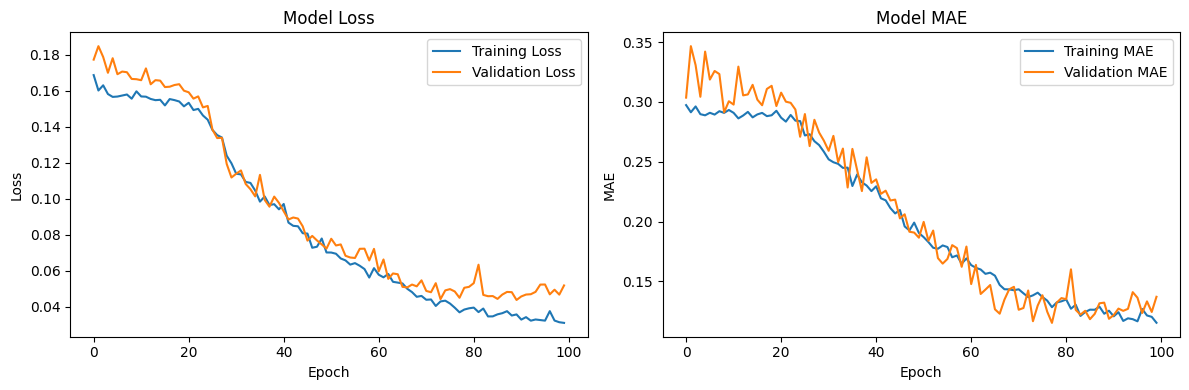

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Make predictions
logger.info("Making predictions...")

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


2025-06-25 11:27:05,921 - INFO - Making predictions...


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [18]:
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
train_mae = mean_absolute_error(y_train_actual, train_predictions)
test_mae = mean_absolute_error(y_test_actual, test_predictions)

In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train_actual, train_predictions)
test_mape = mean_absolute_percentage_error(y_test_actual, test_predictions)

In [20]:
print(f"\n=== LSTM MODEL PERFORMANCE ===")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")


=== LSTM MODEL PERFORMANCE ===
Train RMSE: 1267204.28
Test RMSE: 1624206.93
Train MAE: 776869.64
Test MAE: 921751.06
Train MAPE: 105.33%
Test MAPE: 107.69%


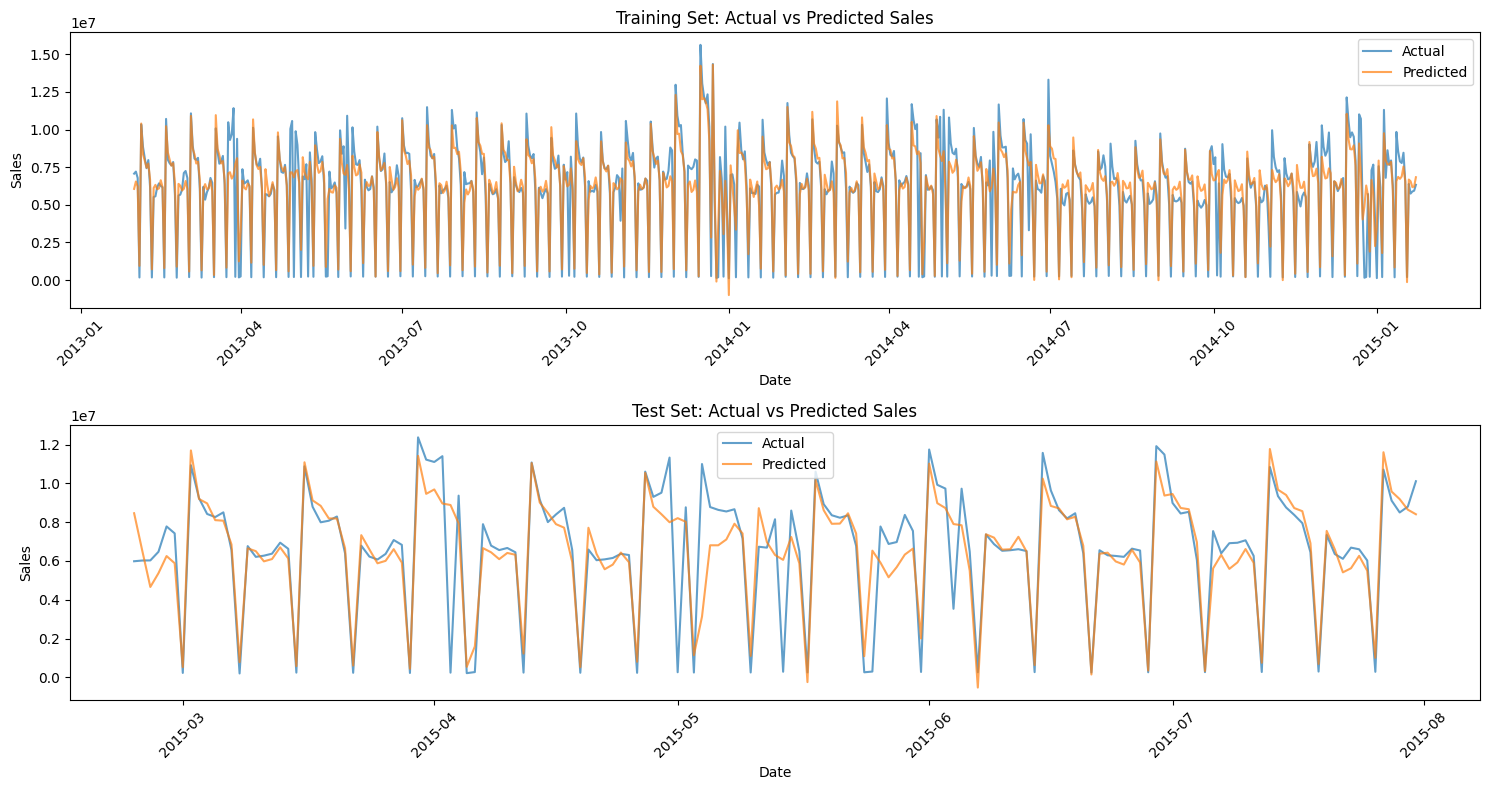

In [21]:
# Plot predictions
plt.figure(figsize=(15, 8))
# Prepare data for plotting
train_dates = daily_sales['Date'][sequence_length:sequence_length+len(train_predictions)]
test_dates = daily_sales['Date'][train_size+sequence_length:train_size+sequence_length+len(test_predictions)]

plt.subplot(2, 1, 1)
plt.plot(train_dates, y_train_actual, label='Actual', alpha=0.7)
plt.plot(train_dates, train_predictions, label='Predicted', alpha=0.7)
plt.title('Training Set: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2, 1, 2)
plt.plot(test_dates, y_test_actual, label='Actual', alpha=0.7)
plt.plot(test_dates, test_predictions, label='Predicted', alpha=0.7)
plt.title('Test Set: Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

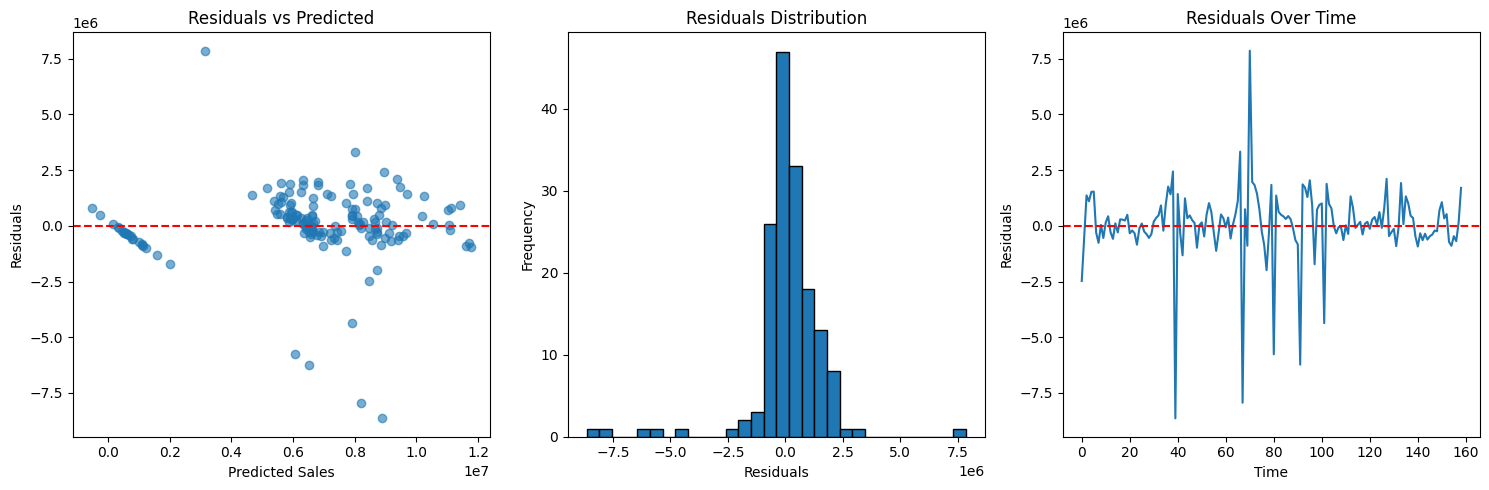

In [22]:
# Residual analysis
test_residuals = y_test_actual.flatten() - test_predictions.flatten()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(test_predictions, test_residuals, alpha=0.6)
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 3, 2)
plt.hist(test_residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

plt.subplot(1, 3, 3)
plt.plot(test_residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

In [23]:
# Future predictions
logger.info("Making future predictions...")

# Use last sequence from test data to predict future
last_sequence = test_scaled[-sequence_length:].reshape(1, sequence_length, 1)
future_predictions = []
future_days = 42  # 6 weeks

current_sequence = last_sequence.copy()

for _ in range(future_days):
    # Predict next value
    next_pred = model.predict(current_sequence, verbose=0)[0, 0]
    future_predictions.append(next_pred)

    # Update sequence (remove first element, add prediction)
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = next_pred

2025-06-25 11:27:25,115 - INFO - Making future predictions...


In [24]:
# Inverse transform future predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

# Create future dates
last_date = daily_sales['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

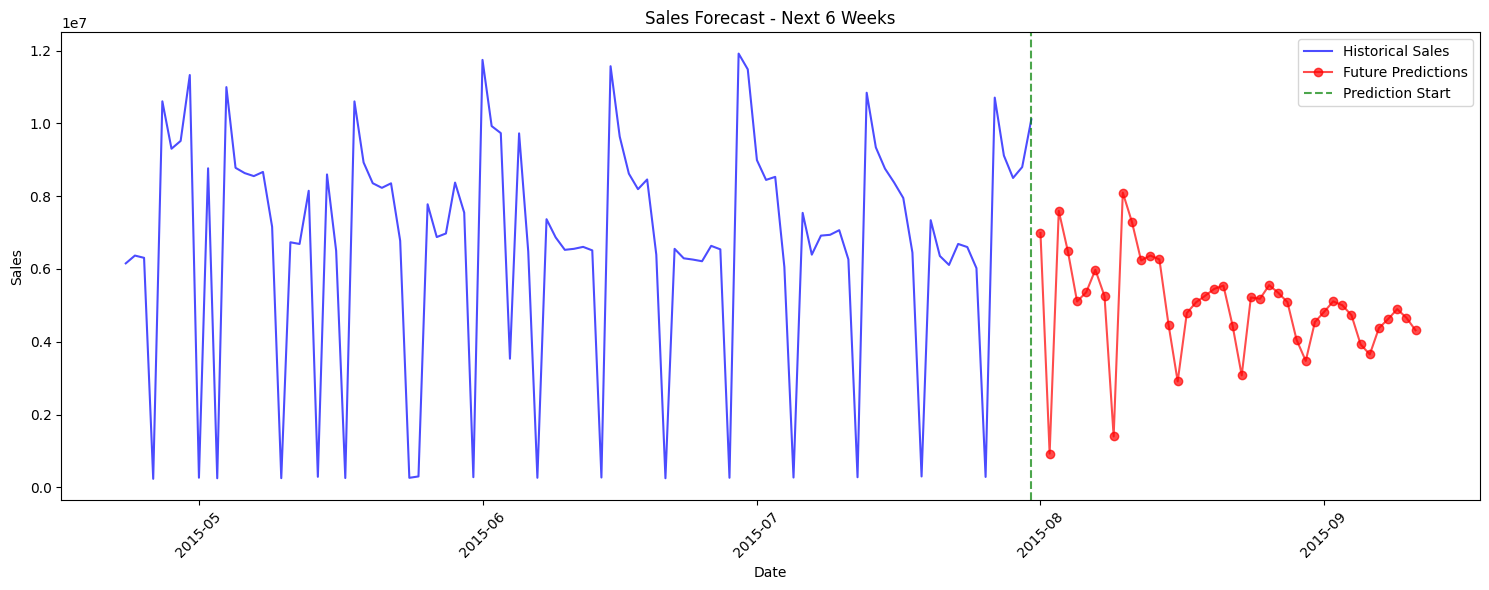

In [25]:
# Plot future predictions
plt.figure(figsize=(15, 6))

# Plot historical data (last 100 days)
historical_data = daily_sales.tail(100)
plt.plot(historical_data['Date'], historical_data['Sales'],
         label='Historical Sales', color='blue', alpha=0.7)

# Plot future predictions
plt.plot(future_dates, future_predictions,
         label='Future Predictions', color='red', alpha=0.7, marker='o')

plt.axvline(x=last_date, color='green', linestyle='--', alpha=0.7, label='Prediction Start')
plt.title('Sales Forecast - Next 6 Weeks')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Save model and results
logger.info("Saving LSTM model and results...")

# Save model
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
model.save(f'lstm_model_{timestamp}.h5')

2025-06-25 11:27:42,009 - INFO - Saving LSTM model and results...
2025-06-25 11:27:42,011 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


In [27]:
# Save scaler
import joblib
joblib.dump(scaler, f'scaler_{timestamp}.pkl')

# Save predictions
results_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Sales': future_predictions.flatten()
})
results_df.to_csv(f'future_predictions_{timestamp}.csv', index=False)


In [28]:
# MLFlow logging
logger.info("Logging LSTM model to MLFlow...")

mlflow.set_experiment("Rossmann LSTM Forecasting")

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("sequence_length", sequence_length)
    mlflow.log_param("lstm_units", 50)
    mlflow.log_param("epochs", len(history.history['loss']))
    mlflow.log_param("batch_size", 32)

    # Log metrics
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_mape", train_mape)
    mlflow.log_metric("test_mape", test_mape)

    # Log model
    mlflow.tensorflow.log_model(model, "lstm_model")

print(f"\n=== FUTURE PREDICTIONS SUMMARY ===")
print(f"Predicted sales for next 6 weeks:")
print(f"Average daily sales: {future_predictions.mean():.0f}")
print(f"Total predicted sales: {future_predictions.sum():.0f}")
print(f"Min daily sales: {future_predictions.min():.0f}")
print(f"Max daily sales: {future_predictions.max():.0f}")

logger.info("LSTM model training and forecasting completed successfully")

2025-06-25 11:29:21,164 - INFO - Logging LSTM model to MLFlow...
2025/06/25 11:29:21 INFO mlflow.tracking.fluent: Experiment with name 'Rossmann LSTM Forecasting' does not exist. Creating a new experiment.
2025/06/25 11:29:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/25 11:29:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/06/25 11:29:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-06-25 11:29:36,706 - INFO - LSTM model training and forecasting completed successfully



=== FUTURE PREDICTIONS SUMMARY ===
Predicted sales for next 6 weeks:
Average daily sales: 4974224
Total predicted sales: 208917408
Min daily sales: 927551
Max daily sales: 8096517
